# 1.

In [1]:
# downloading files by hand because why not

# 2.

In [2]:
import duckdb

In [3]:
db = duckdb.connect("data/duckdb_trains.db")
db

In [4]:
db.sql("""
CREATE TABLE IF NOT EXISTS stations AS
FROM "data/stations-2023-09.csv"
""")

# 3.

In [5]:
db.sql("""
CREATE TABLE IF NOT EXISTS distances AS
    FROM read_csv(
        "data/tariff-distances-2022-01.csv",
        nullstr = 'XXX'
    );
""")

In [6]:
db.sql("""
FROM (DESCRIBE distances)
LIMIT 5;
""")

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AC          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AH          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHP         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHPR        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [7]:
db.sql("""
SELECT #1, #2, #3, #4, #5, #6, #7, #8, #9
FROM distances
LIMIT 8;
""")

┌─────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Station │  AC   │  AH   │  AHP  │ AHPR  │  AHZ  │  AKL  │  AKM  │  ALM  │
│ varchar │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │
├─────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ AC      │  NULL │    82 │    83 │    85 │    90 │    71 │   188 │    32 │
│ AH      │    82 │  NULL │     1 │     3 │     8 │    77 │   153 │    98 │
│ AHP     │    83 │     1 │  NULL │     2 │     9 │    78 │   152 │    99 │
│ AHPR    │    85 │     3 │     2 │  NULL │    11 │    80 │   150 │   101 │
│ AHZ     │    90 │     8 │     9 │    11 │  NULL │    69 │   161 │   106 │
│ AKL     │    71 │    77 │    78 │    80 │    69 │  NULL │   211 │    96 │
│ AKM     │   188 │   153 │   152 │   150 │   161 │   211 │  NULL │   158 │
│ ALM     │    32 │    98 │    99 │   101 │   106 │    96 │   158 │  NULL │
└─────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┘

In [8]:
db.sql("""
CREATE TABLE IF NOT EXISTS distances_long AS
    UNPIVOT distances
    ON COLUMNS (* EXCLUDE station)
    INTO NAME other_station VALUE distance;
""")

In [9]:
db.sql("""
SELECT station, other_station, distance
FROM distances_long
LIMIT 3;
""")

┌─────────┬───────────────┬──────────┐
│ Station │ other_station │ distance │
│ varchar │    varchar    │  int64   │
├─────────┼───────────────┼──────────┤
│ AC      │ AH            │       82 │
│ AC      │ AHP           │       83 │
│ AC      │ AHPR          │       85 │
└─────────┴───────────────┴──────────┘

In [10]:
db.sql("""
SELECT
    s1.name_long AS station1,
    s2.name_long AS station2,
    distances_long.distance
FROM distances_long
JOIN stations s1 ON distances_long.station = s1.code
JOIN stations s2 ON distances_long.other_station = s2.code
WHERE s1.country = 'NL'
  AND s2.country = 'NL'
  AND station < other_station
ORDER BY distance DESC
LIMIT 3;
""")

┌──────────────────┬────────────────────┬──────────┐
│     station1     │      station2      │ distance │
│     varchar      │      varchar       │  int64   │
├──────────────────┼────────────────────┼──────────┤
│ Eemshaven        │ Vlissingen         │      426 │
│ Eemshaven        │ Vlissingen Souburg │      425 │
│ Bad Nieuweschans │ Vlissingen         │      425 │
└──────────────────┴────────────────────┴──────────┘

# 4.

In [11]:
db.sql("""INSTALL postgres; LOAD postgres;""")

# NEVER write password like this explicitly in real code!
conn_string = "host=localhost user=postgres password=postgres dbname=postgres"

In [12]:
db.sql(f"""
ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db (TYPE postgres);
""")

In [13]:
schema_df = db.sql(f"DESCRIBE 'data/disruptions-2023.csv'").df()
schema_df

,column_name,column_type,null,key,default,extra
0,rdt_id,BIGINT,YES,None,None,None
1,ns_lines,VARCHAR,YES,None,None,None
2,rdt_lines,VARCHAR,YES,None,None,None
3,rdt_lines_id,VARCHAR,YES,None,None,None
4,rdt_station_names,VARCHAR,YES,None,None,None
5,rdt_station_codes,VARCHAR,YES,None,None,None
6,cause_nl,VARCHAR,YES,None,None,None
7,cause_en,VARCHAR,YES,None,None,None
8,statistical_cause_nl,VARCHAR,YES,None,None,None
9,statistical_cause_en,VARCHAR,YES,None,None,None


In [14]:
column_defs = []
for index, row in schema_df.iterrows():
    col_name = row['column_name']
    col_type = row['column_type']

    column_defs.append(f'"{col_name}" {col_type}')

column_sql = ",\n    ".join(column_defs)

In [15]:
create_table_sql = f"""
CREATE TABLE IF NOT EXISTS postgres_db.disruptions (
    {column_sql}
);
"""

In [16]:
print(create_table_sql)


CREATE TABLE IF NOT EXISTS postgres_db.disruptions (
    "rdt_id" BIGINT,
    "ns_lines" VARCHAR,
    "rdt_lines" VARCHAR,
    "rdt_lines_id" VARCHAR,
    "rdt_station_names" VARCHAR,
    "rdt_station_codes" VARCHAR,
    "cause_nl" VARCHAR,
    "cause_en" VARCHAR,
    "statistical_cause_nl" VARCHAR,
    "statistical_cause_en" VARCHAR,
    "cause_group" VARCHAR,
    "start_time" TIMESTAMP,
    "end_time" TIMESTAMP,
    "duration_minutes" BIGINT
);



In [17]:
db.sql(create_table_sql)

In [18]:
str_tab = ["INSERT INTO postgres_db.disruptions"]
for i in range(2011, 2024):
    str_tab.append(f"SELECT * FROM 'data/disruptions-{i}.csv'")
    str_tab.append("UNION ALL")

str_tab.pop()

query_insert = "\n    ".join(str_tab)

In [19]:
print(query_insert)

INSERT INTO postgres_db.disruptions
    SELECT * FROM 'data/disruptions-2011.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2012.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2013.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2014.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2015.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2016.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2017.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2018.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2019.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2020.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2021.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2022.csv'
    UNION ALL
    SELECT * FROM 'data/disruptions-2023.csv'


In [20]:
db.sql(query_insert)

In [21]:
db.sql("""
SELECT * FROM postgres_db.disruptions LIMIT 3
""").df()

,rdt_id,ns_lines,rdt_lines,rdt_lines_id,rdt_station_names,rdt_station_codes,cause_nl,cause_en,statistical_cause_nl,statistical_cause_en,cause_group,start_time,end_time,duration_minutes
0,40500,Den Haag-Rotterdam; Leiden-Rotterdam,Den Haag HS - Rotterdam Centraal,11,"Delft,Delft Campus,Den Haag HS,Den Haag Moerwi...","DT, DTCP, GV, GVMW, RSW",brandmelding,fire alarm,brandmelding,fire alarm,external,2022-01-01 05:45:33,2022-01-01 06:34:58,49
1,40501,Amsterdam-Utrecht; Utrecht-Eindhoven,"'s-Hertogenbosch - Utrecht Centraal, Amsterdam...","136,151","Abcoude,Amsterdam Amstel,Amsterdam Bijlmer Are...","AC, ASA, ASB, ASD, ASDM, ASHD, BKL, CL, DVD, G...",herstelwerkzaamheden,repair works,herstelwerkzaamheden,repair works,engineering work,2022-01-01 06:23:54,2022-01-01 13:59:14,455
2,40502,Schiphol-Rotterdam (HSL),Rotterdam Centraal - Schiphol Airport (HSL),24,"Rotterdam Centraal,Schiphol Airport","RTD, SHL",brandmelding,fire alarm,brandmelding,fire alarm,external,2022-01-01 06:33:40,2022-01-01 06:34:27,1


# 5.

In [22]:
db.sql("COPY (FROM 'data/services-20*.csv') TO 'data/services.parquet' (FORMAT PARQUET, CODEC ZSTD);")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [23]:
db.sql("""
CREATE TABLE IF NOT EXISTS services AS
FROM 'data/services.parquet'
""")

# 6. Six was a lie!

# 7.

In [24]:
db.sql("""
SELECT COUNT(*) FROM services
WHERE "Stop:Departure cancelled" = 'false' AND "Stop:Departure time" IS NOT NULL AND "Stop:Station name" = 'Amsterdam Centraal'
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1735131 │
└──────────────┘

In [25]:
db.sql("""
SELECT "Service:Type",
       AVG("Stop:Arrival delay") AS avg_arrival_delay
FROM services
WHERE "Stop:Arrival delay" IS NOT NULL
GROUP BY "Service:Type"
ORDER BY avg_arrival_delay DESC
""")

┌──────────────────────┬────────────────────┐
│     Service:Type     │ avg_arrival_delay  │
│       varchar        │       double       │
├──────────────────────┼────────────────────┤
│ Alpen Express        │  31.84254143646409 │
│ Krokus Express       │ 18.304347826086957 │
│ European Sleeper     │ 14.730917608156517 │
│ Nightjet             │  9.256974238121135 │
│ Eurostar             │  7.221416941972401 │
│ ICE International    │  5.482790573052148 │
│ Thalys               │ 5.3961896909446025 │
│ Int. Trein           │ 4.9727022780832675 │
│ Nachttrein           │ 3.7960975609756096 │
│ Stoomtrein           │  3.366863905325444 │
│     ·                │                 ·  │
│     ·                │                 ·  │
│     ·                │                 ·  │
│ Taxibus ipv trein    │                0.0 │
│ Bus                  │                0.0 │
│ Belbus               │                0.0 │
│ Metro                │                0.0 │
│ stoptrein            │          

In [26]:
db.sql("""
SELECT MODE("cause_en")AS cause_en,
       YEAR("start_time") AS year
FROM postgres_db.disruptions
GROUP BY YEAR("start_time")
""")

┌───────────────────┬───────┐
│     cause_en      │ year  │
│      varchar      │ int64 │
├───────────────────┼───────┤
│ broken down train │  2016 │
│ broken down train │  2020 │
│ points failure    │  2012 │
│ broken down train │  2011 │
│ broken down train │  2021 │
│ broken down train │  2018 │
│ broken down train │  2014 │
│ broken down train │  2019 │
│ points failure    │  2013 │
│ broken down train │  2017 │
│ broken down train │  2022 │
│ broken down train │  2023 │
│ broken down train │  2015 │
├───────────────────┴───────┤
│ 13 rows         2 columns │
└───────────────────────────┘

In [27]:
db.sql("""
SELECT COUNT(*) FROM services
WHERE "Stop:Departure cancelled" = 'false' AND "Stop:Arrival time" IS NULL AND "Stop:Station name" LIKE '%Amsterdam%'
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1142042 │
└──────────────┘

In [28]:
db.sql("""
SELECT (
    SELECT COUNT(*)
    FROM services

    INNER JOIN stations
    ON services."Stop:Station code" = stations.code


    WHERE "Stop:Arrival cancelled" = 'false' AND "Stop:Departure time" IS NULL AND stations.country	 != 'NL'
    ) / COUNT(*) AS fraction_of_services_final_destination_outside_netherlands
FROM services
""")

┌────────────────────────────────────────────────────────────┐
│ fraction_of_services_final_destination_outside_netherlands │
│                           double                           │
├────────────────────────────────────────────────────────────┤
│                                      0.0038246043730004093 │
└────────────────────────────────────────────────────────────┘

In [29]:
db.sql("""
SELECT
    s1.name_long AS station1,
    s2.name_long AS station2,
    distances_long.distance
FROM distances_long
JOIN stations s1 ON distances_long.station = s1.code
JOIN stations s2 ON distances_long.other_station = s2.code
WHERE s1.country = 'NL'
  AND s2.country = 'NL'
  AND station < other_station
ORDER BY distance DESC
LIMIT 1;
""")

┌───────────┬────────────┬──────────┐
│ station1  │  station2  │ distance │
│  varchar  │  varchar   │  int64   │
├───────────┼────────────┼──────────┤
│ Eemshaven │ Vlissingen │      426 │
└───────────┴────────────┴──────────┘

In [30]:
company_avg_delay = db.sql("""
SELECT "Service:Company",
       AVG("Stop:Arrival delay") AS avg_delay
FROM services
GROUP BY "Service:Company"
ORDER BY avg_delay DESC
""").df()

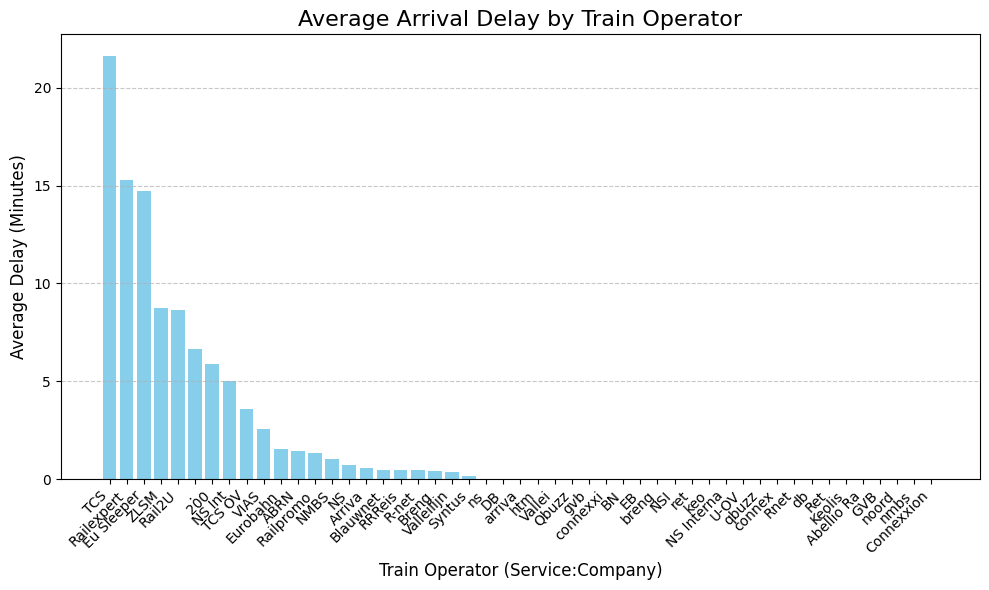

In [31]:
import matplotlib.pyplot as plt

df_sorted = company_avg_delay.sort_values(by="avg_delay", ascending=False)

companies = df_sorted["Service:Company"]
avg_delays = df_sorted["avg_delay"]

plt.figure(figsize=(10, 6))

plt.bar(
    companies,
    avg_delays,
    color='skyblue'
)

plt.title("Average Arrival Delay by Train Operator", fontsize=16)
plt.xlabel("Train Operator (Service:Company)", fontsize=12)
plt.ylabel("Average Delay (Minutes)", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
disruptions_by_year = db.sql("""
SELECT COUNT(*) AS disruptions_number,
       YEAR("start_time") AS year
FROM postgres_db.disruptions
GROUP BY year
ORDER BY year ASC
""").df()

<Axes: title={'center': 'Number of disruptions by year'}, xlabel='year'>

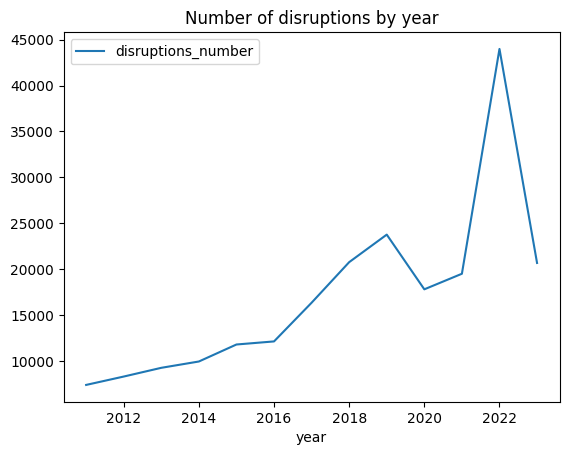

In [33]:
disruptions_by_year.plot.line(
    x="year", y="disruptions_number", title="Number of disruptions by year"
)

In [34]:
fraction_services_canceled_per_year = db.sql("""
SELECT
  YEAR("Service:Date") AS year,
  SUM(CASE WHEN "Service:Completely cancelled" = 'true' THEN 1 ELSE 0 END) * 1.0 /
  COUNT(*) AS cancel_fraction
FROM services
GROUP BY YEAR("Service:Date")
ORDER BY year ASC
""").df()

<Axes: title={'center': 'Fraction of services canceled each year'}, xlabel='year'>

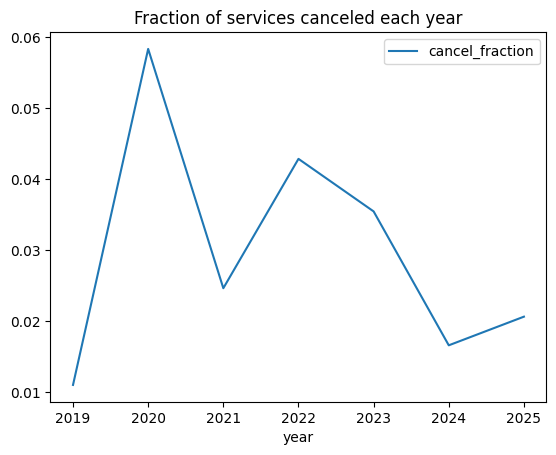

In [35]:
fraction_services_canceled_per_year.plot.line(
    x="year", y="cancel_fraction", title="Fraction of services canceled each year"
)

# 8.

I don't know how to fix issue shown below, where the same train has its start_station in TWO PLACES AT THE SAME TIME. I am just gonna ignore it and hope to get an answer in feedback.pdf

In [65]:
db.sql("""
SELECT (*) FROM services
WHERE "Service:RDT-ID" = 12150120
ORDER BY "Stop:Departure Time" ASC, "Stop:Arrival time" ASC
LIMIT 15
""").df()

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change,Stop:Planned platform,Stop:Actual platform
0,12150120,2023-10-07,Stopbus ipv trein,Arriva,945002,False,False,0,109426692,STD,Sittard,NaT,<NA>,<NA>,2023-10-07 17:20:00+02:00,0,False,False,None,None
1,12150120,2023-10-07,Stopbus ipv trein,Arriva,945002,False,False,0,109429756,ST,Soest,NaT,<NA>,<NA>,2023-10-07 17:20:00+02:00,0,False,False,None,None
2,12150120,2023-10-07,Stopbus ipv trein,Arriva,945002,False,False,0,109426693,GLN,Geleen Oost,2023-10-07 17:29:00+02:00,0,False,2023-10-07 17:29:00+02:00,0,False,False,None,None
3,12150120,2023-10-07,Stopbus ipv trein,Arriva,945002,False,False,0,109426694,SBK,Spaubeek,2023-10-07 17:36:00+02:00,0,False,2023-10-07 17:36:00+02:00,0,False,False,None,None
4,12150120,2023-10-07,Stopbus ipv trein,Arriva,945002,False,False,0,109426695,SN,Schinnen,2023-10-07 17:45:00+02:00,0,False,2023-10-07 17:45:00+02:00,0,False,False,None,None
5,12150120,2023-10-07,Stopbus ipv trein,Arriva,945002,False,False,0,109426696,NH,Nuth,2023-10-07 17:49:00+02:00,0,False,2023-10-07 17:49:00+02:00,0,False,False,None,None
6,12150120,2023-10-07,Stopbus ipv trein,Arriva,945002,False,False,0,109426697,HB,Hoensbroek,2023-10-07 17:57:00+02:00,0,False,2023-10-07 17:57:00+02:00,0,False,False,None,None
7,12150120,2023-10-07,Stopbus ipv trein,Arriva,945002,False,False,0,109426698,HRL,Heerlen,2023-10-07 18:05:00+02:00,0,False,NaT,<NA>,<NA>,False,None,None


In [82]:
db.sql("""
CREATE TABLE IF NOT EXISTS station_connections AS
WITH start_stops AS (
    SELECT
        "Service:RDT-ID",
        "Stop:Station code" AS start_station_code
    FROM services
    WHERE "Service:Completely cancelled" != 'true' AND "Stop:Arrival time" IS NULL AND "Stop:Departure time" IS NOT NULL AND "Stop:Departure cancelled" != 'true'
    QUALIFY "Stop:Departure time" = MIN("Stop:Departure time")
        OVER (PARTITION BY "Service:RDT-ID")
),
final_stops AS (
    SELECT
        "Service:RDT-ID",
        "Stop:Station code" AS end_station_code
    FROM services
    WHERE "Service:Completely cancelled" != 'true' AND "Stop:Departure time" IS NULL AND "Stop:Arrival time" IS NOT NULL AND "Stop:Arrival cancelled" != 'true'
    QUALIFY "Stop:Arrival time" = MAX("Stop:Arrival time")
        OVER (PARTITION BY "Service:RDT-ID")
)
SELECT
    s."Service:RDT-ID",
    s.start_station_code,
    f.end_station_code,
    d.distance
FROM start_stops s
JOIN final_stops f
    ON s."Service:RDT-ID" = f."Service:RDT-ID"
JOIN distances_long d
    ON s.start_station_code = d.Station AND f.end_station_code = d.other_station
ORDER BY s."Service:RDT-ID"
""")

In [95]:
db.sql("""
SELECT (*)
FROM station_connections
ORDER BY distance DESC
LIMIT 1
""")

┌────────────────┬────────────────────┬──────────────────┬──────────┐
│ Service:RDT-ID │ start_station_code │ end_station_code │ distance │
│     int64      │      varchar       │     varchar      │  int64   │
├────────────────┼────────────────────┼──────────────────┼──────────┤
│        7122512 │ GS                 │ STV              │      396 │
└────────────────┴────────────────────┴──────────────────┴──────────┘

In [97]:
distances_df = db.sql("""
SELECT * FROM station_connections
""").df()

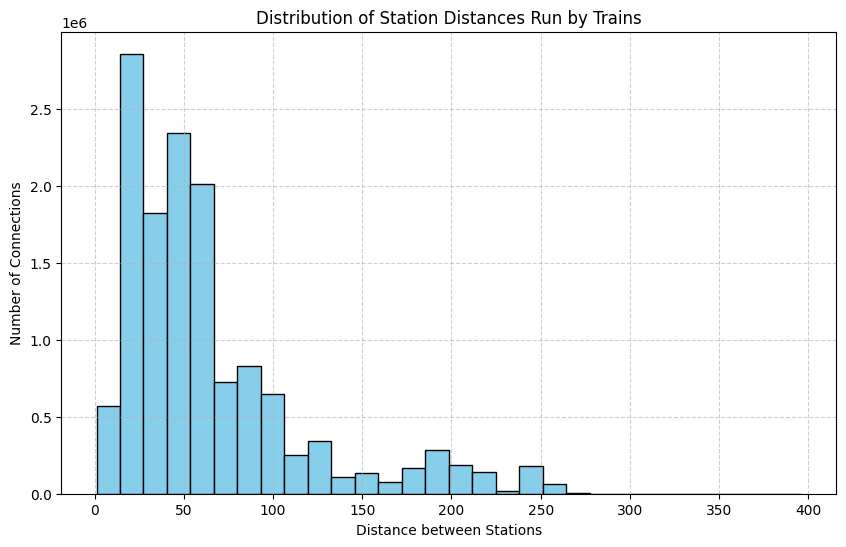

In [99]:
distances_df['distance'].hist(
    bins=30,
    figsize=(10, 6),
    color='skyblue',
    edgecolor='black'
)

plt.title('Distribution of Station Distances Run by Trains')
plt.xlabel('Distance between Stations')
plt.ylabel('Number of Connections')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()